In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import sklearn
import random
import sys
import os
import matplotlib.pyplot as plt
import math
import scipy
from distcorr import distcorr
from fractions import gcd
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [248]:
def fill_nan(array, REPLACE_COUNT):
    NAN = 0
    array.flat[np.random.choice(array.size, int(REPLACE_COUNT), replace=False)] = NAN

    return array

In [249]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

In [250]:
# ENABLE/DISABLE GPU
# UNCOMMENT to.device() FOR TENSORS AND NEURAL NETWORKS TO ENABLE GPU

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
np.set_printoptions(threshold=sys.maxsize, precision=2, suppress=True)

In [251]:
dataset = pd.read_csv('breast/breast.csv')
dataset

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [252]:
# NARROW THE FEATURES
array = np.array(['radius_mean', 'perimeter_mean', 'area_mean', 'radius_worst', 'perimeter_worst', 'area_worst'])
processed_data = dataset[array]
processed_data

,radius_mean,perimeter_mean,area_mean,radius_worst,perimeter_worst,area_worst
0,17.99,122.80,1001.0,25.380,184.60,2019.0
1,20.57,132.90,1326.0,24.990,158.80,1956.0
2,19.69,130.00,1203.0,23.570,152.50,1709.0
3,11.42,77.58,386.1,14.910,98.87,567.7
4,20.29,135.10,1297.0,22.540,152.20,1575.0
...,...,...,...,...,...,...
564,21.56,142.00,1479.0,25.450,166.10,2027.0
565,20.13,131.20,1261.0,23.690,155.00,1731.0
566,16.60,108.30,858.1,18.980,126.70,1124.0
567,20.60,140.10,1265.0,25.740,184.60,1821.0


In [253]:
# for i in range(len(processed_data.columns)):
#     for j in range(i+1, len(processed_data.columns)):
#         corr, _ = pearsonr(processed_data[processed_data.columns[i]], processed_data[processed_data.columns[j]])
#         print("PEARSONR: ", processed_data.columns[i], processed_data.columns[j], corr)
#         print("DCORR: ", processed_data.columns[i], processed_data.columns[j], distcorr(processed_data[processed_data.columns[j]], processed_data[processed_data.columns[i]]))

In [254]:
# for i in range(len(processed_data.columns)):
#     for j in range(i+1, len(processed_data.columns)):
#         processed_data.plot(x=processed_data.columns[i], y=processed_data.columns[j], style='o')

In [255]:
# CONVERT TO NUMPY
numpy_data = processed_data.to_numpy()
numpy_data[0]

array([  17.99,  122.8 , 1001.  ,   25.38,  184.6 , 2019.  ])

In [256]:
# NORMALIZE THE DATA
scaled_data = scaler.fit_transform(numpy_data)

In [257]:
# SPLIT INTO TRAIN/TEST SETS (0.8 / 0.2)
trainset = scaled_data[:455, :]
testset = scaled_data[455:, :]
trainset

 0.4 , 0.37, 0.24],
       [0.42, 0.41, 0.27, 0.44, 0.43, 0.27],
       [0.58, 0.61, 0.42, 0.46, 0.5 , 0.28],
       [0.42, 0.41, 0.27, 0.32, 0.31, 0.17],
       [0.32, 0.34, 0.18, 0.25, 0.29, 0.13],
       [0.36, 0.37, 0.22, 0.34, 0.37, 0.19],
       [0.36, 0.35, 0.23, 0.4 , 0.36, 0.23],
       [0.43, 0.44, 0.28, 0.46, 0.43, 0.28],
       [0.61, 0.6 , 0.47, 0.69, 0.68, 0.54],
       [0.31, 0.3 , 0.18, 0.26, 0.25, 0.13],
       [0.29, 0.29, 0.16, 0.23, 0.23, 0.11],
       [0.12, 0.11, 0.06, 0.08, 0.07, 0.03],
       [0.4 , 0.41, 0.24, 0.36, 0.37, 0.2 ],
       [0.67, 0.65, 0.53, 0.76, 0.69, 0.6 ],
       [0.46, 0.46, 0.32, 0.66, 0.63, 0.5 ],
       [0.48, 0.5 , 0.33, 0.51, 0.51, 0.31],
       [0.36, 0.37, 0.21, 0.34, 0.36, 0.17],
       [0.55, 0.54, 0.4 , 0.48, 0.45, 0.3 ],
       [0.39, 0.41, 0.25, 0.44, 0.49, 0.27],
       [0.5 , 0.49, 0.34, 0.43, 0.42, 0.26],
       [0.55, 0.56, 0.4 , 0.54, 0.55, 0.36],
       [0.23, 0.24, 0.13, 0.32, 0.34, 0.17],
       [0.48, 0.48, 0.32, 0.46, 0.4

In [258]:
full_data_train = trainset.copy()

missing_data_train = fill_nan(trainset, trainset.size*0.2)

full_data_test = testset.copy()

missing_data_test = fill_nan(testset, testset.size*0.2) 

In [259]:
missing_data_train[1]

array([0.  , 0.62, 0.5 , 0.61, 0.  , 0.44])

In [260]:
full_data_train[1]

array([0.64, 0.62, 0.5 , 0.61, 0.54, 0.44])

In [268]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=6, out_features=4)
        self.enc2 = nn.Linear(in_features=4, out_features=3)
        self.enc3 = nn.Linear(in_features=3, out_features=2)

        self.dec1 = nn.Linear(in_features=2, out_features=3)
        self.dec2 = nn.Linear(in_features=3, out_features=4)
        self.dec3 = nn.Linear(in_features=4, out_features=6)

    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = F.leaky_relu(self.enc2(x))
        x = F.leaky_relu(self.enc3(x))
        x = F.leaky_relu(self.dec1(x))
        x = F.leaky_relu(self.dec2(x))
        x = self.dec3(x)
        return x

In [269]:
# CREATE A SEED FOR CONSISTENT WEIGHT INITIALIZATIONS - FOR TESTING PURPOSES
random.seed(1)
torch.manual_seed(random.randint(1, 10))
net = Autoencoder().double()
#net.to(device)

In [270]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
BATCH_SIZE = -1
NUM_FEATURES = 6
BATCH_SIZE_TEST = -1

In [271]:
x_train = torch.from_numpy(missing_data_train)
#x_train = x_train.to(device)
x_train = x_train.view(BATCH_SIZE, NUM_FEATURES)

y_train = torch.from_numpy(full_data_train)
#y_train = y_train.to(device)
y_train = y_train.view(BATCH_SIZE, NUM_FEATURES)

x_test = torch.from_numpy(missing_data_test)
#x_test = x_test.to(device)
x_test = x_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

y_test = torch.from_numpy(full_data_test)
#y_test = y_test.to(device)
y_test = y_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

x_train.shape

torch.Size([455, 6])

In [272]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [273]:
def train(net):
    train_loss = []
    torch.set_printoptions(precision=2, sci_mode=True)
    np.set_printoptions(precision=2, suppress=True)

    for epoch in range(NUM_EPOCHS):
        # running_loss: LOSS OF THE PREDICTED MISSING VALUE ONLY
        # overall_loss: LOSS OF ALL RECONSTRUCTED VALUES

        running_loss = 0.0
        overall_loss = 0.0
        count = 0
        for missing_data, full_data in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
            
            # COMPUTE LOSS OF PREDICTED MISSING VALUE
            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            # PRINT ALL VALUES ON LAST EPOCH FOR TESTING PURPOSES
            if epoch == NUM_EPOCHS-1:
                if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                    print("Input: ", scaler.inverse_transform(missing_data.reshape(-1,6)))
                    print("Target: ", scaler.inverse_transform(full_data.reshape(-1,6)))
                    print("Outputs: ", scaler.inverse_transform(outputs.reshape(-1,6).detach().numpy()))
                else:
                    print("Input (missing): ", scaler.inverse_transform(missing_data.reshape(-1,6)))
                    print("Target (missing): ", scaler.inverse_transform(full_data.reshape(-1,6)))
                    print("Outputs (missing): ", scaler.inverse_transform(outputs.reshape(-1,6).detach().numpy()))
        
      #  loss = running_loss / count
        overall_loss = overall_loss / len(x_train)
        train_loss.append(loss)

        print('Epoch {} of {}, Train Loss: {:.5f}, Overall: {:.5f}'
             .format(epoch+1, NUM_EPOCHS, loss, overall_loss))

    return train_loss


def test(net):

    net.eval()
    count = 0

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0

        for missing_data, full_data in zip(x_test, y_test):
            outputs = net(missing_data.double())
            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                print("Input: ", scaler.inverse_transform(missing_data.reshape(-1,6)))
                print("Target: ", scaler.inverse_transform(full_data.reshape(-1,6)))
                print("Outputs: ", scaler.inverse_transform(outputs.reshape(-1,6).detach().numpy()))
            else:
                print("Input (missing): ", scaler.inverse_transform(missing_data.reshape(-1,6)))
                print("Target (missing): ", scaler.inverse_transform(full_data.reshape(-1,6)))
                print("Outputs (missing): ", scaler.inverse_transform(outputs.reshape(-1,6).detach().numpy()))

        loss = running_loss / count
        test_loss.append(loss)
        print('Test Loss: {:.3f}'.format(loss))

        return test_loss

In [274]:
# TRAIN THE NEURAL NETWORK
results = train(net)

17.36 119.4  915.3 ]]
Outputs:  [[  15.94  104.38  843.47   18.67  123.51 1174.54]]
Input (missing):  [[   6.98  174.2  2010.     33.13  229.3  3234.  ]]
Target (missing):  [[  25.73  174.2  2010.     33.13  229.3  3234.  ]]
Outputs (missing):  [[  24.02  157.8  1588.78   30.1   200.08 2454.34]]
Input (missing):  [[  15.08   98.    143.5    18.51   50.41 1050.  ]]
Target (missing):  [[  15.08   98.    716.6    18.51  121.2  1050.  ]]
Outputs (missing):  [[ 13.24  85.47 568.99  14.91  97.27 735.98]]
Input (missing):  [[  6.98  71.24 384.6   12.12  79.62 453.5 ]]
Target (missing):  [[ 11.14  71.24 384.6   12.12  79.62 453.5 ]]
Outputs (missing):  [[ 11.45  73.02 388.39  12.43  79.99 447.55]]
Input (missing):  [[ 12.56  81.92 143.5   13.37  89.02 547.4 ]]
Target (missing):  [[ 12.56  81.92 485.8   13.37  89.02 547.4 ]]
Outputs (missing):  [[ 12.04  77.08 447.25  13.25  85.74 543.58]]
Input (missing):  [[ 13.05  85.09 512.    14.19  50.41 591.2 ]]
Target (missing):  [[ 13.05  85.09 512.   

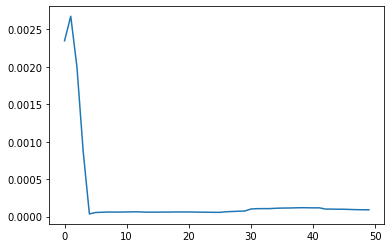

In [190]:
plt.plot(results)

In [73]:
results

[170279234.30305684,
 138486134.61194178,
 110773168.49276383,
 88453608.27910532,
 70731948.64458226,
 56723724.97336765,
 45653600.96831522,
 36879183.13999028,
 29793215.741121653,
 23813477.911298532,
 18732942.649670172,
 14439353.859978395,
 10891050.2468269,
 8102343.64095194,
 5960953.678186786,
 4365876.044024943,
 3236494.3921400844,
 2488403.9228668,
 2032144.7433381414,
 1760479.5041925116,
 1395694.6248402463,
 244925.31745750207,
 83840.74366943064,
 65736.26907693066,
 59701.30568325996,
 54306.840197102916,
 49385.774551097005,
 44765.81866709603,
 40372.665517638896,
 36355.42702802669,
 32650.590218158955,
 28753.968907201146,
 24614.899725488634,
 21795.670647818377,
 19436.020001090215,
 17221.80849605999,
 15218.129236173016,
 13373.11880461031,
 11688.519846144862,
 10157.745595875918,
 8783.786599250332,
 7555.624498783478,
 6472.573663091766,
 5527.3120353833965,
 4706.698978034632,
 4003.790964164612,
 3410.8958791798527,
 2914.893940231815,
 2506.5459052187384

In [191]:
# TEST THE NEURAL NETWORK
test_result = test(net)

 100.4  734.6 ]]
Outputs (missing):  [[ 13.31  85.88 544.95  14.49  95.61 640.56]]
Input:  [[ 11.6   73.88 412.7   12.77  82.68 495.1 ]]
Target:  [[ 11.6   73.88 412.7   12.77  82.68 495.1 ]]
Outputs:  [[ 11.58  74.25 423.85  12.56  82.27 494.49]]
Input (missing):  [[  6.98  84.28 537.3   14.9   95.1  687.6 ]]
Target (missing):  [[ 13.17  84.28 537.3   14.9   95.1  687.6 ]]
Outputs (missing):  [[ 12.24  78.67 469.9   13.3   87.34 550.04]]
Input (missing):  [[ 13.24  86.87 143.5   15.44 115.   733.5 ]]
Target (missing):  [[ 13.24  86.87 542.9   15.44 115.   733.5 ]]
Outputs (missing):  [[ 12.99  83.72 522.51  14.13  93.14 613.52]]
Input (missing):  [[ 13.14  85.98 536.9   14.8   50.41 689.1 ]]
Target (missing):  [[ 13.14  85.98 536.9   14.8  100.9  689.1 ]]
Outputs (missing):  [[ 12.37  79.56 479.2   13.44  88.36 561.32]]
Input (missing):  [[  9.67  43.79 286.3   11.15  71.11 380.2 ]]
Target (missing):  [[  9.67  61.06 286.3   11.15  71.11 380.2 ]]
Outputs (missing):  [[  9.39  59.54 27

In [192]:
torch.save(net, './breast_autoencoder3')

# The following section is for reconstructing a brand new dataset from an input dataset that has missing values.
# This new dataset can be used in some classifiers to see if the accuracy changes.

In [240]:
dataset = pd.read_csv('breast/breast.csv')
array = np.array(['radius_mean', 'perimeter_mean', 'area_mean', 'radius_worst', 'perimeter_worst', 'area_worst'])
filtered_data = dataset[array]
filtered_data

,radius_mean,perimeter_mean,area_mean,radius_worst,perimeter_worst,area_worst
0,17.99,122.80,1001.0,25.380,184.60,2019.0
1,20.57,132.90,1326.0,24.990,158.80,1956.0
2,19.69,130.00,1203.0,23.570,152.50,1709.0
3,11.42,77.58,386.1,14.910,98.87,567.7
4,20.29,135.10,1297.0,22.540,152.20,1575.0
...,...,...,...,...,...,...
564,21.56,142.00,1479.0,25.450,166.10,2027.0
565,20.13,131.20,1261.0,23.690,155.00,1731.0
566,16.60,108.30,858.1,18.980,126.70,1124.0
567,20.60,140.10,1265.0,25.740,184.60,1821.0


In [241]:
np.set_printoptions(precision=4, suppress=True)
scaled_set = scaler.fit_transform(filtered_data.to_numpy())
scaled_set

[0.6067, 0.5937, 0.4609, 0.6332, 0.5971, 0.4482],
       [0.5939, 0.5819, 0.4579, 0.7104, 0.6464, 0.5633],
       [0.3156, 0.3047, 0.1804, 0.2636, 0.2455, 0.128 ],
       [0.3114, 0.3096, 0.1772, 0.2508, 0.2525, 0.1232],
       [0.1514, 0.1474, 0.0719, 0.1153, 0.1072, 0.0468],
       [0.415 , 0.4064, 0.2621, 0.4137, 0.376 , 0.2219],
       [0.2976, 0.2817, 0.1709, 0.2565, 0.2412, 0.1287],
       [0.3483, 0.3367, 0.2111, 0.3145, 0.2988, 0.1691],
       [0.1637, 0.1578, 0.0789, 0.1277, 0.1148, 0.0517],
       [0.3795, 0.3708, 0.2295, 0.3017, 0.3177, 0.1531],
       [0.2669, 0.2596, 0.1497, 0.2231, 0.2005, 0.1078],
       [0.2768, 0.2866, 0.1526, 0.2586, 0.2734, 0.128 ],
       [0.4765, 0.481 , 0.3188, 0.4148, 0.4138, 0.2467],
       [0.2054, 0.1933, 0.107 , 0.1476, 0.1465, 0.0656],
       [0.2006, 0.1866, 0.1032, 0.1576, 0.1396, 0.0702],
       [0.6403, 0.6261, 0.4986, 0.5884, 0.5592, 0.4146],
       [0.1224, 0.1135, 0.0577, 0.0918, 0.0763, 0.037 ],
       [0.3336, 0.3179, 0.1951, 0.2633

In [242]:
missing_data = fill_nan(scaled_data, scaled_data.size*0.2)

input_tensor = torch.from_numpy(missing_data)
input_tensor = input_tensor.view(input_tensor.shape[0], NUM_FEATURES)

In [243]:
input_tensor

tensor([[0.0000, 0.5460, 0.3637, 0.6208, 0.6683, 0.4507],
        [0.6431, 0.0000, 0.5016, 0.0000, 0.5398, 0.4352],
        [0.6015, 0.5957, 0.4494, 0.5564, 0.5084, 0.3745],
        ...,
        [0.4553, 0.4458, 0.0000, 0.3931, 0.3799, 0.0000],
        [0.6446, 0.6655, 0.0000, 0.0000, 0.6683, 0.4020],
        [0.0369, 0.0285, 0.0159, 0.0543, 0.0436, 0.0205]], dtype=torch.float64)

In [244]:
my_model = torch.load('breast_autoencoder3')
my_model

Autoencoder(
  (enc1): Linear(in_features=6, out_features=4, bias=True)
  (enc2): Linear(in_features=4, out_features=3, bias=True)
  (enc3): Linear(in_features=3, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=3, bias=True)
  (dec2): Linear(in_features=3, out_features=4, bias=True)
  (dec3): Linear(in_features=4, out_features=6, bias=True)
)

In [245]:
new_dataset = my_model(input_tensor.double())
torch.set_printoptions(precision=4, sci_mode=False)
new_dataset

tensor([[0.5451, 0.5367, 0.3880, 0.4945, 0.4702, 0.3162],
        [0.4707, 0.4615, 0.3166, 0.4151, 0.3939, 0.2476],
        [0.5940, 0.5875, 0.4454, 0.5469, 0.5239, 0.3739],
        ...,
        [0.3305, 0.3218, 0.1962, 0.2658, 0.2553, 0.1356],
        [0.4777, 0.4684, 0.3226, 0.4225, 0.4008, 0.2531],
        [0.0564, 0.0521, 0.0178, 0.0297, 0.0278, 0.0053]], dtype=torch.float64,
       grad_fn=<AddmmBackward>)

In [246]:
new_dataset = scaler.inverse_transform(new_dataset.detach().numpy())
new_dataset

777,  866.0888,   19.2463,  127.1696, 1154.2572],
       [   9.1222,   57.7154,  251.7255,    9.8216,   63.3015,  286.7583],
       [   7.6546,   47.8477,  149.4457,    8.1878,   51.9996,  163.9222],
       [   8.6782,   54.7291,  220.6866,    9.3267,   59.8776,  249.3709],
       [  10.4269,   66.493 ,  343.1335,   11.277 ,   73.3726,  397.0921],
       [   8.3575,   52.5715,  198.2041,    8.9689,   57.4015,  222.216 ],
       [  11.4594,   73.4387,  415.4787,   12.4287,   81.3425,  484.4336],
       [  11.3737,   72.8616,  409.4034,   12.3327,   80.6776,  477.0165],
       [   9.2014,   58.2484,  257.2903,    9.91  ,   63.9137,  293.4933],
       [  12.6562,   81.4891,  499.1931,   13.7629,   90.5743,  585.3242],
       [  11.0649,   70.7846,  387.8276,   11.9885,   78.2968,  451.0428],
       [  10.415 ,   66.4124,  342.2576,   11.2634,   73.2787,  395.9874],
       [   8.2848,   52.0832,  193.1563,    8.8881,   56.8427,  216.171 ],
       [   9.6768,   61.4466,  290.6066,   10.4404

In [247]:
np.savetxt('new_breast.csv', new_dataset)